In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = ':https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F39466%2F61155%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240913%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240913T062356Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Daa94a4d2159fdf2dbd8b32ae059393faf6806b75d31b80caacce7e36996317e23e444ef797df0ab3dc3b6f78afa25abfba825910aaa7fc9f014fd630e9bc3cc2ced77381c98e7b74c1c6848eabdfbcff8d3ed88416818e92668082fa1c11163bc1610256ed1b4547bab4bc98247dd11fd0d935a933e1218421bde73d0b9cb60be3d19f81bd3745e8ccb7dc56f92c4324c8cfed5377ace70d9ae5ce2582080132869db6b49986e04b8a6edaf2f25712e63698ffe2c7d0b32cef6c1df855ad53301f9bf2ea0f511fc6e69299159e0a6f83243ca24fb70f035c7b77fbecdd68a677ec44d64bae30da4901b281d607d034be2076d9ccfe91696bae800b5f5cc3807b'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 2286085038 bytes downloaded
Downloaded and uncompressed: 
Data source import complete.


## Please upvote if you like it ;)

# Import Modules

In [3]:
# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# data visualisation and manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

#model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

#preprocess.
#preprocess.
from tensorflow.keras.preprocessing.image import ImageDataGenerator # Changed import statement to use tensorflow.keras

#dl libraraies
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint,EarlyStopping,TensorBoard,CSVLogger,ReduceLROnPlateau,LearningRateScheduler

# specifically for cnn
from keras.layers import Dropout, Flatten,Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization,GlobalAveragePooling2D
import tensorflow as tf
import random as rn

# specifically for manipulating zipped images and getting numpy arrays of pixel values of images.
import cv2
import numpy as np
from tqdm import tqdm
import os
from random import shuffle
from zipfile import ZipFile
from PIL import Image

# Make Data

In [4]:
lookup = dict()
reverselookup = dict()
count = 0
for j in os.listdir('../input/leapgestrecog/leapGestRecog/00/'):
    if not j.startswith('.'): # If running this code locally, this is to
                              # ensure you aren't reading in hidden folders
        lookup[j] = count
        reverselookup[count] = j
        count = count + 1
lookup

{'10_down': 0,
 '03_fist': 1,
 '01_palm': 2,
 '06_index': 3,
 '02_l': 4,
 '07_ok': 5,
 '05_thumb': 6,
 '04_fist_moved': 7,
 '09_c': 8,
 '08_palm_moved': 9}

In [5]:
x_data = []
y_data = []
IMG_SIZE = 150
datacount = 0 # We'll use this to tally how many images are in our dataset
for i in range(0, 10): # Loop over the ten top-level folders
    for j in os.listdir('../input/leapgestrecog/leapGestRecog/0' + str(i) + '/'):
        if not j.startswith('.'): # Again avoid hidden folders
            count = 0 # To tally images of a given gesture
            for k in os.listdir('../input/leapgestrecog/leapGestRecog/0' +
                                str(i) + '/' + j + '/'):
                                # Loop over the images
                path = '../input/leapgestrecog/leapGestRecog/0' + str(i) + '/' + j + '/' + k
                img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
                img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
                arr = np.array(img)
                x_data.append(arr)
                count = count + 1
            y_values = np.full((count, 1), lookup[j])
            y_data.append(y_values)
            datacount = datacount + count
x_data = np.array(x_data, dtype = 'float32')
y_data = np.array(y_data)
y_data = y_data.reshape(datacount, 1) # Reshape to be the correct size

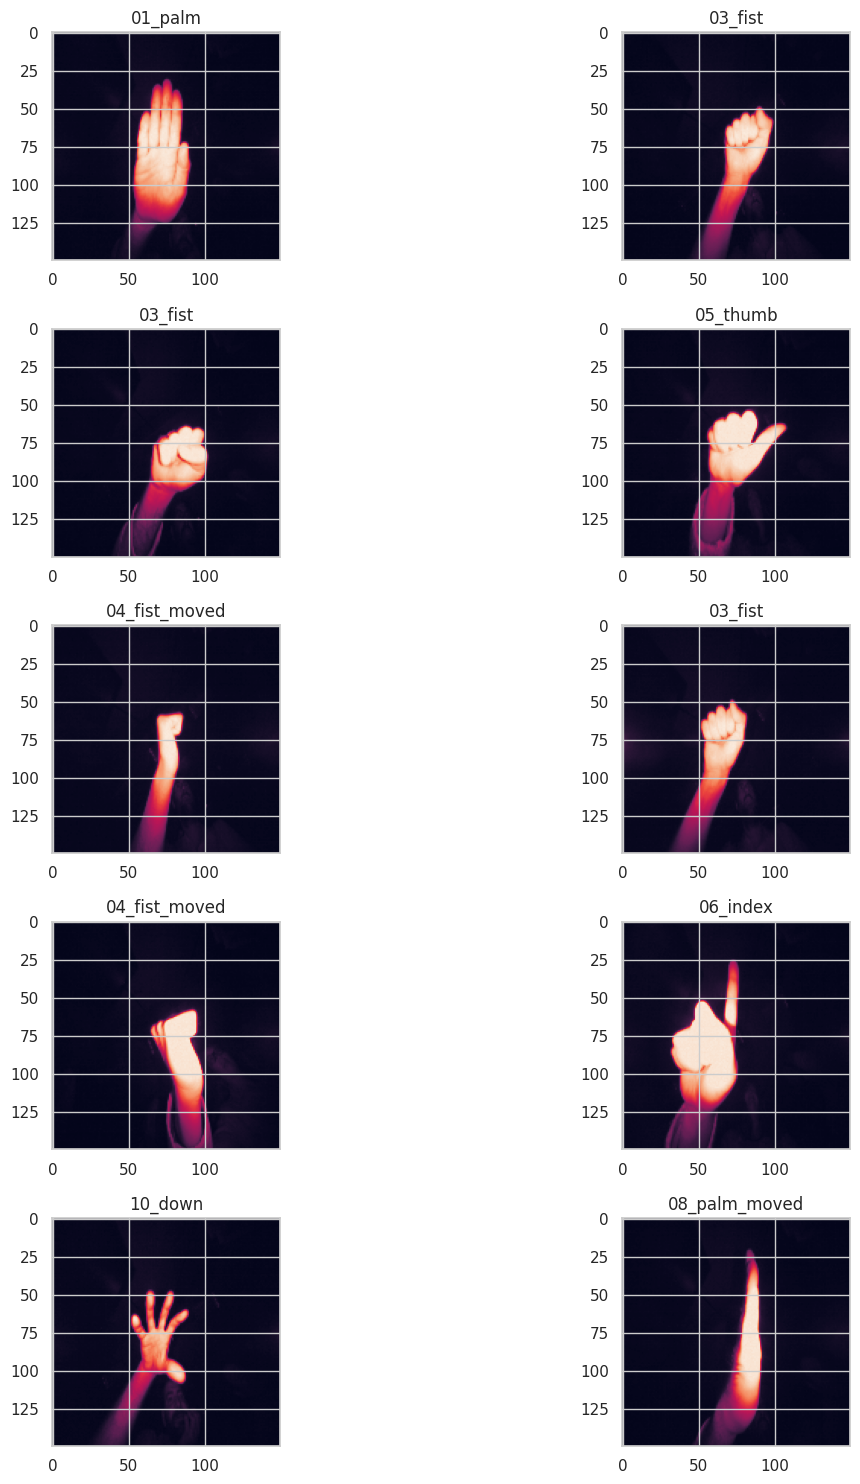

In [6]:
# check some image
fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range (2):
        l=rn.randint(0,len(y_data))
        ax[i,j].imshow(x_data[l])
        ax[i,j].set_title(reverselookup[y_data[l,0]])

plt.tight_layout()

In [7]:
y_data=to_categorical(y_data)
x_data = x_data.reshape((datacount, IMG_SIZE, IMG_SIZE, 1))
x_data = x_data/255

In [8]:
x_train,x_test,y_train,y_test=train_test_split(x_data,y_data,test_size=0.25,random_state=42)

# Model Build

In [9]:
model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',activation ='relu', input_shape = (IMG_SIZE,IMG_SIZE,1)))
model.add(MaxPooling2D(pool_size=(2,2)))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))


model.add(Conv2D(filters =96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters = 96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(10, activation = "softmax"))

In [10]:
batch_size=128
epochs=10

In [16]:
checkpoint = ModelCheckpoint(
    './base.model.keras',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min',
    save_weights_only=False,
    #period=1
    save_freq="epoch"
)
earlystop = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=30,
    verbose=1,
    mode='auto'
)
tensorboard = TensorBoard(
    log_dir = './logs',
    histogram_freq=0,
    #batch_size=16,
    write_graph=True,
   # write_grads=True,
    write_images=False,
)

csvlogger = CSVLogger(
    filename= "training_csv.log",
    separator = ",",
    append = False
)

reduce = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    verbose=1,
    mode='auto'
)

callbacks = [checkpoint,tensorboard,csvlogger,reduce]

In [20]:
model.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

In [21]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 150, 150, 32)        │             832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 75, 75, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 75, 75, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 37, 37, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 37, 37, 96)          │          55,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 18, 18, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 18, 18, 96)          │          83,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 9, 9, 96)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 7776)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       3,981,824 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           5,130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,144,714 (15.81 MB)

 Trainable params: 4,144,714 (15.81 MB)

 Non-trainable params: 0 (0.00 B)

# Train

In [22]:
History = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(x_test, y_test),callbacks=callbacks)

Epoch 1/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.6897 - loss: 0.8973
Epoch 1: val_loss improved from inf to 0.02058, saving model to ./base.model.keras
118/118 ━━━━━━━━━━━━━━━━━━━━ 882s 7s/step - accuracy: 0.6913 - loss: 0.8928 - val_accuracy: 0.9946 - val_loss: 0.0206 - learning_rate: 0.0010
Epoch 2/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9980 - loss: 0.0070
Epoch 2: val_loss improved from 0.02058 to 0.01664, saving model to ./base.model.keras
118/118 ━━━━━━━━━━━━━━━━━━━━ 921s 7s/step - accuracy: 0.9980 - loss: 0.0070 - val_accuracy: 0.9934 - val_loss: 0.0166 - learning_rate: 0.0010
Epoch 3/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9915 - loss: 0.0324
Epoch 3: val_loss improved from 0.01664 to 0.00342, saving model to ./base.model.keras
118/118 ━━━━━━━━━━━━━━━━━━━━ 905s 7s/step - accuracy: 0.9915 - loss: 0.0322 - val_accuracy: 0.9990 - val_loss: 0.0034 - learning_rate: 0.0010
Epoch 4/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy:

# Check Result

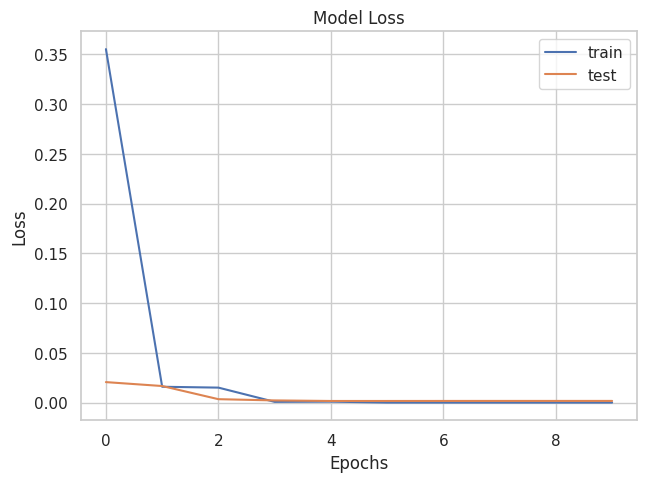

In [23]:
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

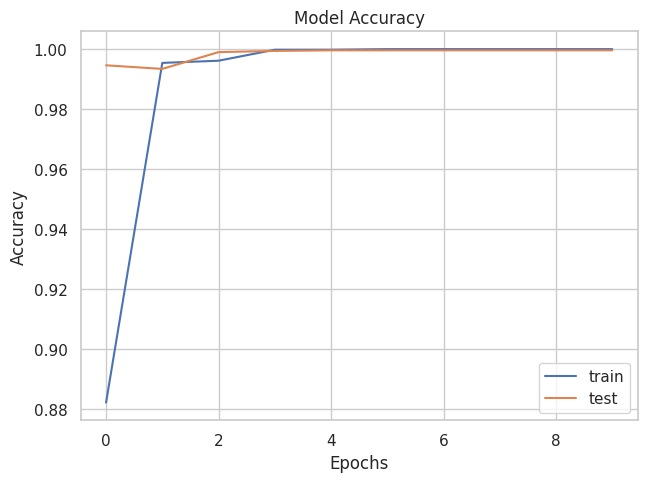

In [26]:
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

## Please upvote if you like it;)